In [1]:
import pandas as pd
import numpy as np
from utils import *
import pytensor.tensor as pt  # Import PyTensor (Theano backend)
import pickle
import xarray as xr


df, scaling_factors = read_dd_data('../data/PD_data',standardize=True, reduced_data=False)

In [3]:
df_train, df_test = split_train_test(df, test_size=0.2)

Train set size: 7808 trials
Test set size: 1941 trials
Test set percentage: 19.9%


In [4]:
df = df_train

In [ ]:
df.describe()

,rcert,runcert,event_prob,choice,condition,rt,odds,participant_idx
count,7808.000000,7808.000000,7808.000000,7808.000000,7808.000000,7808.000000,7808.000000,7808.000000
mean,-0.031965,-0.011452,0.499782,0.393699,1.520492,0.062999,2.699966,24.007172
std,0.999954,1.001390,0.298936,0.488601,0.499612,0.995200,3.324739,14.144824
min,-2.037028,-8.083318,0.100000,0.000000,1.000000,-3.943414,0.111111,0.000000
25%,-0.409626,-0.068188,0.250000,0.000000,1.000000,-0.478220,0.333333,12.000000
50%,-0.043460,-0.002657,0.500000,0.000000,2.000000,0.109419,1.000000,24.000000
75%,0.404075,0.046692,0.750000,1.000000,2.000000,0.709859,3.000000,36.000000
max,2.031478,8.081948,0.900000,1.000000,2.000000,2.557909,9.000000,48.000000


In [6]:
def create_model_parameters(n_participants, config="default"):
    """
    Create group and participant-level parameters for the probabilistic discounting model.
    
    Args:
        n_participants (int): Number of participants in the study
        config (str): Configuration name for different parameter setups
        
    Returns:
        dict: Dictionary containing all model parameters
    """
    with pm.Model() as temp_model:

        # Initialize all parameters as None
        mu_k_raw = None
        mu_k = None
        sigma_k_raw = None 
        sigma_k = None
        mu_beta = None
        sigma_beta = None
        mu_beta0 = None
        sigma_beta0 = None
        mu_beta1 = None
        sigma_beta1 = None
        mu_sigma_RT = None
        sigma_sigma_RT = None
        k_raw = None
        k = None
        beta = None
        beta0 = None
        beta1 = None
        sigma_RT = None
        mu_lambda = None
        sigma_lambda = None
        lambda_raw = None
        loss_aversion = None
        beta2 = None
        group_beta2_mu = None
        group_beta2_sigma = None

       
        # Group-level priors
        mu_k_raw = pm.Normal("mu_k_raw", mu=0, sigma=1)  # Reduced sigma back to 1
        mu_k = pm.Deterministic("mu_k", pm.math.exp(mu_k_raw))

        sigma_k_raw = pm.HalfNormal("sigma_k_raw", sigma=1)  # Reduced sigma back to 1
        sigma_k = pm.Deterministic("sigma_k", pm.math.exp(sigma_k_raw))

        mu_beta = pm.Normal("mu_beta", mu=0, sigma=1)  # Changed to Normal
        sigma_beta = pm.HalfNormal("sigma_beta", sigma=0.5)  # Reduced sigma

        mu_beta0 = pm.Normal("mu_beta0", mu=0, sigma=1)
        sigma_beta0 = pm.HalfNormal("sigma_beta0", sigma=0.5)  # Reduced sigma

        mu_beta1 = pm.Normal("mu_beta1", mu=0, sigma=5)  # Changed to Normal
        sigma_beta1 = pm.HalfNormal("sigma_beta1", sigma=2)  # Reduced sigma

        sigma_sigma_RT = pm.HalfNormal("sigma_sigma_RT", sigma=1)  # Reduced sigma

        # loss aversion parameter (lambda)
        mu_lambda = pm.Normal("mu_lambda", mu=1, sigma=0.5)  # Group-level loss aversion
        sigma_lambda = pm.HalfNormal("sigma_lambda", sigma=0.5)
        lambda_raw = pm.Normal("lambda_raw", mu=0, sigma=1, shape=n_participants)

        # Participant-level parameters
        k_raw = pm.Normal("k_raw", mu=0, sigma=1, shape=n_participants)
        k = pm.Deterministic("k", pm.math.exp(mu_k + sigma_k * k_raw))  # Removed scaling factor

        beta = pm.Normal("beta", mu=mu_beta, sigma=sigma_beta, shape=n_participants)  # Changed to Normal
        beta0 = pm.Normal("beta0", mu=mu_beta0, sigma=sigma_beta0, shape=n_participants)
        beta1 = pm.Normal("beta1", mu=mu_beta1, sigma=sigma_beta1, shape=n_participants)  # Changed to Normal
        sigma_RT = pm.HalfNormal("sigma_RT", sigma=sigma_sigma_RT, shape=n_participants) 
        loss_aversion = pm.Deterministic("loss_aversion", pm.math.exp(mu_lambda + sigma_lambda * lambda_raw))
    
        if config == 'quadratic':
            group_beta2_mu = pm.Normal("group_beta2_mu", mu=0, sigma=2)
            group_beta2_sigma = pm.HalfNormal("group_beta2_sigma", sigma=2)
            beta2 = pm.Normal("beta2", mu=group_beta2_mu, sigma=group_beta2_sigma, shape=n_participants)
        
        # Get all parameters from the model
        params = {
            'group_level': {
                'mu_k': mu_k,
                'sigma_k': sigma_k,
                'mu_beta': mu_beta,
                'sigma_beta': sigma_beta,
                'mu_beta0': mu_beta0,
                'sigma_beta0': sigma_beta0,
                'mu_beta1': mu_beta1,
                'sigma_beta1': sigma_beta1,
                'mu_sigma_RT': mu_sigma_RT,
                'sigma_sigma_RT': sigma_sigma_RT,
                'mu_lambda': mu_lambda,
                'sigma_lambda': sigma_lambda,
                'group_beta2_mu': group_beta2_mu,
                'group_beta2_sigma': group_beta2_sigma
            },
            'participant_level': {
                'k': k,
                'beta': beta,
                'beta0': beta0,
                'beta1': beta1,
                'sigma_RT': sigma_RT,
                'loss_aversion': loss_aversion,
                'beta2': beta2
            }
        }
        
    return params

In [7]:
def create_choice_discounting_model(df, config="default", params=None):
    """
    Create a probabilistic discounting model for the given dataframe.

    Args:
        df (pd.DataFrame): The dataframe containing the data

    Returns:
        dict: A dictionary containing the model parameters
    """

    choice = None

    # Extract observed data
    rcert = df["rcert"].values
    runcert = df["runcert"].values
    participant_ids = df["participant_idx"].values  # Integer IDs
    event_prob = df["event_prob"].values
    choice_data = df["choice"].astype(int).values  # Ensure it's an integer for Bernoulli

    if config == "loss-aversion":

        k = params['participant_level']['k']
        loss_aversion = params['participant_level']['loss_aversion']
        beta = params['participant_level']['beta']

        # For gains (condition 1)
        gains_mask = df['condition'] == 1

        SV_certain = pm.math.switch(gains_mask, 
                                rcert,  # gains
                                -loss_aversion[participant_ids] * rcert)  # losses
        
        SV_uncertain = pm.math.switch(gains_mask,
                                    runcert / (1 + k[participant_ids] * event_prob),  # gains
                                    -loss_aversion[participant_ids] * runcert / (1 + k[participant_ids] * event_prob))  # losses

        # Choice model (Bernoulli with logistic function)
        max_exp = 10
        exp = beta[participant_ids] * (SV_uncertain - SV_certain) # TODO: check order of SV_uncertain and SV_certain
        exp = pm.math.clip(exp, -max_exp, max_exp)

        prob_choose_uncertain = pm.Deterministic("prob_choose_uncertain",
            pm.math.sigmoid(exp) 
        )
        choice = pm.Bernoulli("choice", p=prob_choose_uncertain, observed=choice_data)

    elif config == "default":
        
        k = params['participant_level']['k']
        beta = params['participant_level']['beta']

        # Compute subjective values using hyperbolic discounting
        SV_certain = rcert
        SV_uncertain = runcert / (1 + k[participant_ids] * event_prob)

        # Choice model (Bernoulli with logistic function)
        max_exp = 10
        exp = beta[participant_ids] * (SV_uncertain - SV_certain) # TODO: check order of SV_uncertain and SV_certain
        exp = pm.math.clip(exp, -max_exp, max_exp)

        prob_choose_uncertain = pm.Deterministic("prob_choose_uncertain",
            pm.math.sigmoid(exp) 
        )
        choice = pm.Bernoulli("choice", p=prob_choose_uncertain, observed=choice_data)
    
    else:
        raise ValueError(f"Unknown configuration: {config}")
    
    return choice, SV_certain, SV_uncertain

In [8]:
def create_rt_model(df, config="default", params=None,
                     decision_difficulty=None,
                     n_participants: int =None):
    """
    Create a reaction time model for the given dataframe.

    Args:
        df (pd.DataFrame): The dataframe containing the data

    """
    mu_RT = None
    rt_data = df["rt"].values
    # Extract observed data
    participant_ids = df["participant_idx"].values  # Integer IDs
    beta0 = params['participant_level']['beta0']
    beta1 = params['participant_level']['beta1']
    beta2 = params['participant_level']['beta2']
    sigma_RT = params['participant_level']['sigma_RT']

    if config == "default":
        '''
        Linear reaction time model with trial-specific adjustment based on decision difficulty
        Sigma is scaled by a coefficient gamma that is drawn from a normal distribution
        Sigma is specific to each participant and to each trial

        The returned value is a standardized log_RT, which is a normal distribution with a mean and a standard deviation
        '''
        mu_RT = pm.Deterministic("mu_RT", beta0[participant_ids] + beta1[participant_ids] * decision_difficulty)
        standardized_log_RT = pm.Normal("log_RT", mu=mu_RT, sigma=sigma_RT[participant_ids], observed=rt_data)
        return standardized_log_RT

    elif config == "sigma-per-trial":

        gamma = pm.Normal("gamma", mu=0, sigma=1)  # coefficient for difficulty effect on variability
        # Combine base sigma with trial-specific adjustment
        sigma_RT_trial = pm.Deterministic(
            "sigma_RT_trial",
            sigma_RT[participant_ids] * (1 + gamma * decision_difficulty)
        )
        mu_RT = pm.Deterministic("mu_RT", beta0[participant_ids] + beta1[participant_ids] * decision_difficulty)
        standardized_log_RT = pm.Normal("log_RT", mu=mu_RT, sigma=sigma_RT_trial, observed=rt_data)
        return standardized_log_RT
    
    elif config == "quadratic":
       
        mu_RT = pm.Deterministic("mu_RT", beta0[participant_ids] + beta1[participant_ids] * decision_difficulty + beta2[participant_ids] * decision_difficulty**2)
        standardized_log_RT = pm.Normal("log_RT", mu=mu_RT, sigma=sigma_RT[participant_ids], observed=rt_data)
        return standardized_log_RT
    
    elif config == 'ddm':
        # TODO
        pass
    else:
        raise ValueError(f"Unknown configuration: {config}")
 
        

In [9]:
def create_decision_difficulty(SV_uncertain, SV_certain, config="default"):
    if config == "default":
        return (SV_uncertain - SV_certain) ** 2
    elif config == "absolute-value":
        return np.abs(SV_uncertain - SV_certain)

In [10]:
def fit_model(df, config="default", 
                no_participants=None,
                save_path: str = None,
                plot_trace: bool = False,
                plot_path: str = None):
    
    with pm.Model() as model:
        # Create parameters
        params = create_model_parameters(no_participants, config=config)
        
        # Create choice model
        choice, SV_certain, SV_uncertain = create_choice_discounting_model(
            df, 
            config="loss-aversion", 
            params=params
        )
        
        # Create RT model using the SVs from choice model
        decision_difficulty = create_decision_difficulty(SV_uncertain, SV_certain, config="absolute-value")
        standardized_log_RT = create_rt_model(
            df, 
            params=params, 
            decision_difficulty=decision_difficulty,
            config=config
        )
        
        # Sample
        model.debug(verbose=True)
        trace = pm.sample(2000, tune=1000,
                            target_accept=0.90,
                            return_inferencedata=True,
                            init='jitter+adapt_diag',
                            cores=4,
                            chains=4,
                            mp_ctx='spawn',
                            idata_kwargs={'log_likelihood': True})
        
        if save_path is not None:
            # trace.posterior.to_netcdf(save_path)
            trace.to_netcdf(save_path)

        if plot_trace:
            # Trace plot: Check parameter convergence across chains
            trace_plot = az.plot_trace(trace, var_names=["mu_k", "mu_beta", "mu_beta0", "mu_beta1"])
            plt.savefig(plot_path + '/trace_plot.png')
            plt.show()
            plt.close()

            # Posterior distributions: Check inferred parameter values
            posterior_plot = az.plot_posterior(trace, var_names=["mu_k", "mu_beta", "mu_beta0", "mu_beta1"])
            plt.savefig(plot_path + '/posterior_plot.png')
            plt.show()
            plt.close()

            # Energy plot: Helps diagnose divergences
            energy_plot = az.plot_energy(trace)
            plt.savefig(plot_path + '/energy_plot.png')
            plt.show()
            plt.close()

            # Pair plot for key parameters (shows correlation structure)
            pair_plot = az.plot_pair(trace, var_names=["mu_k", "mu_beta", "mu_beta0", "mu_beta1"], kind="scatter", divergences=True)
            plt.savefig(plot_path + '/pair_plot.png')
            plt.show()
            plt.close()
    
        return model

In [ ]:
participants = df["participant"].unique()
n_participants = len(participants)

model = fit_model(df, config="default",
            no_participants=n_participants,
            save_path="models/linear_model.nc",
            plot_trace=True,
            plot_path="plots/linear-model-all-data")


model = fit_model(df, config="quadratic",
            no_participants=n_participants,
            save_path="models/quadratic_model.nc",
            plot_trace=True,
            plot_path="plots/quadratic-model-all-data")

point={'mu_k_raw': array(0.), 'sigma_k_raw_log__': array(0.), 'mu_beta': array(0.), 'sigma_beta_log__': array(-0.69314718), 'mu_beta0': array(0.), 'sigma_beta0_log__': array(-0.69314718), 'mu_beta1': array(0.), 'sigma_beta1_log__': array(0.69314718), 'sigma_sigma_RT_log__': array(0.), 'mu_lambda': array(1.), 'sigma_lambda_log__': array(-0.69314718), 'lambda_raw': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'k_raw': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'beta': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_k_raw, sigma_k_raw, mu_beta, sigma_beta, mu_beta0, sigma_beta0, mu_beta1, sigma_beta1, sigma_sigma_RT, mu_lambda, sigma_lambda, lambda_raw, k_raw, beta, beta0, beta1, sigma_RT]


Output()

Sampling 4 chains for 1_000 tune and 1_145 draw iterations (4_000 + 4_580 draws total) took 2625 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [10]:
trace = az.from_netcdf("models/quadratic_model.nc")

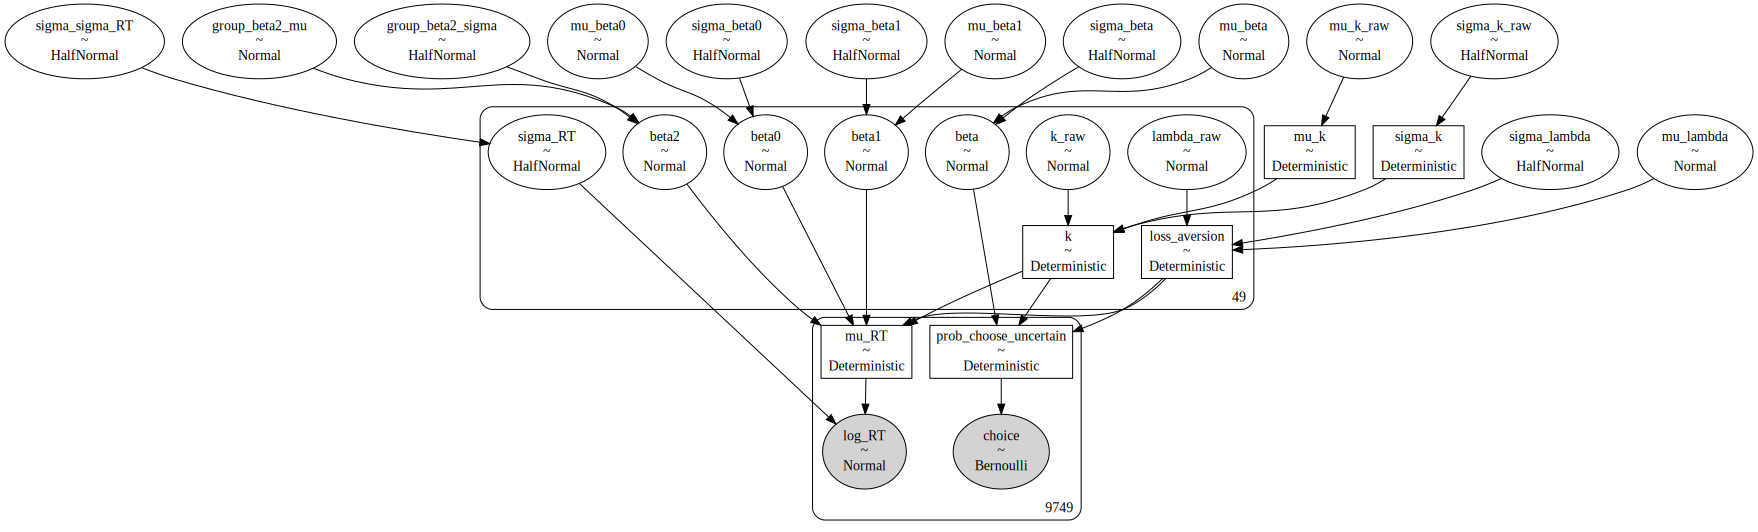

In [11]:
pm.model_to_graphviz(model)


In [12]:
import arviz as az
import matplotlib.pyplot as plt


In [13]:
# Check effective sample size (ESS): Should be > 200 per chain
ess_values = az.ess(trace)
print("\nEffective Sample Size (ESS) per parameter:")
print("----------------------------------------")
for param, value in ess_values.items():
    if isinstance(value.values, np.ndarray):
        print(f"\n{param}:")
        print(f"  Mean ESS: {value.values.mean():.1f}")
        print(f"  Min ESS:  {value.values.min():.1f}")
        print(f"  Max ESS:  {value.values.max():.1f}")
    else:
        print(f"\n{param}: {float(value):.1f}")



Effective Sample Size (ESS) per parameter:
----------------------------------------

mu_k_raw:
  Mean ESS: 232.1
  Min ESS:  232.1
  Max ESS:  232.1

mu_beta:
  Mean ESS: 5505.0
  Min ESS:  5505.0
  Max ESS:  5505.0

mu_beta0:
  Mean ESS: 665.2
  Min ESS:  665.2
  Max ESS:  665.2

mu_beta1:
  Mean ESS: 117.3
  Min ESS:  117.3
  Max ESS:  117.3

mu_lambda:
  Mean ESS: 39.9
  Min ESS:  39.9
  Max ESS:  39.9

lambda_raw:
  Mean ESS: 1642.8
  Min ESS:  7.2
  Max ESS:  6135.2

k_raw:
  Mean ESS: 1911.9
  Min ESS:  39.7
  Max ESS:  4217.7

beta:
  Mean ESS: 2489.0
  Min ESS:  6.8
  Max ESS:  8667.5

beta0:
  Mean ESS: 3227.6
  Min ESS:  7.1
  Max ESS:  8276.0

beta1:
  Mean ESS: 2272.2
  Min ESS:  6.7
  Max ESS:  6346.1

group_beta2_mu:
  Mean ESS: 345.2
  Min ESS:  345.2
  Max ESS:  345.2

beta2:
  Mean ESS: 1152.2
  Min ESS:  229.9
  Max ESS:  1845.1

sigma_k_raw:
  Mean ESS: 897.7
  Min ESS:  897.7
  Max ESS:  897.7

sigma_beta:
  Mean ESS: 96.0
  Min ESS:  96.0
  Max ESS:  96.0

sigma_b

In [14]:
check_convergence_rhat(trace)

/opt/miniconda3/envs/humml/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


=== Convergence Analysis (R-hat) ===


Group-level means:
------------------
✓ mu_k: 1.017
✓ mu_beta: 1.009
✓ mu_beta0: 1.008
✓ mu_beta1: 1.031
⚪ mu_sigma_RT: Not found in trace

Group-level standard deviations:
--------------------------------
✓ sigma_k: 1.006
✓ sigma_beta: 1.035
✓ sigma_beta0: 1.006
✓ sigma_beta1: 1.013
✓ sigma_sigma_RT: 1.003

Individual-level parameters:
----------------------------
⚠️ k:
    mean: 1.007
    max:  1.076
    min:  1.001
⚠️ beta:
    mean: 1.022
    max:  1.571
    min:  1.001
⚠️ beta0:
    mean: 1.018
    max:  1.536
    min:  1.001
⚠️ beta1:
    mean: 1.021
    max:  1.596
    min:  1.002
⚠️ sigma_RT:
    mean: 1.008
    max:  1.194
    min:  1.000

Deterministic variables:
------------------------
⚠️ prob_choose_uncertain:
    mean: nan
    max:  nan
    min:  nan
⚠️ mu_RT:
    mean: 1.015
    max:  1.602
    min:  1.000

=== Summary ===
❌ Convergence issues detected!

Parameters requiring attention:
  - k (max: 1.076)
  - beta (max: 1.571)
  - be

In [15]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data